# Task 1 Skeleton Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import re
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.io as sio
plt.rcParams['figure.figsize'] = 10,10

import sklearn.datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Original Data

In [2]:
my_iris_data = sklearn.datasets.load_iris()
print ("my_iris_data.data.shape:",my_iris_data.data.shape)
print ("labels:",my_iris_data.target)

my_iris_data.data.shape: (150, 4)
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [3]:
X_train = np.concatenate((my_iris_data.data[10:50,:],my_iris_data.data[60:100,:], my_iris_data.data[110:150,:]))
X_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train),axis=1) # Append bias term 1
y_train = np.concatenate((my_iris_data.target[10:50],my_iris_data.target[60:100], my_iris_data.target[110:150]))
print ("X_train.shape:", X_train.shape)
print ("y_train.shape:", y_train.shape)

X_test = np.concatenate((my_iris_data.data[40:50,:],my_iris_data.data[90:100,:], my_iris_data.data[140:150,:]))
X_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1) # Append bias term 1
y_test = np.concatenate((my_iris_data.target[40:50],my_iris_data.target[90:100], my_iris_data.target[140:150]))
print ("X_test.shape:", X_test.shape)
print ("y_test.shape:", y_test.shape)
# print(X_train)
# print(y_train)
# print(X_train[0].shape)
# print((X_train.shape[1],1))
# print(y_train[0])

X_train.shape: (120, 5)
y_train.shape: (120,)
X_test.shape: (30, 5)
y_test.shape: (30,)


## Preprocess the labels to get 3 datasets

In [4]:
y_train1 = np.copy(y_train); y_test1 = np.copy(y_test)
y_train2 = np.copy(y_train); y_test2 = np.copy(y_test)
y_train3 = np.copy(y_train); y_test3 = np.copy(y_test)

y_train1[y_train == 1] = -1
y_train1[y_train == 2] = -1
y_train1[y_train == 0] = 1
y_test1[y_test == 1] = -1
y_test1[y_test == 2] = -1
y_test1[y_test == 0] = 1

y_train2[y_train == 1] = 1
y_train2[y_train == 2] = -1
y_train2[y_train == 0] = -1
y_test2[y_test == 1] = 1
y_test2[y_test == 2] = -1
y_test2[y_test == 0] = -1

y_train3[y_train == 1] = -1
y_train3[y_train == 2] = 1
y_train3[y_train == 0] = -1
y_test3[y_test == 1] = -1
y_test3[y_test == 2] = 1
y_test3[y_test == 0] = -1

## Task 1: OvA SVM on iris
We use gradient descent to train 3 SVMs

Original target function: 

$ L(\textbf{w}) = \frac{1}{2} \left \| \textbf{w} \right \|^2 + C \sum_i max(0, 1- y_i \times <\textbf{x}_i, \textbf{w}>) $

The gradient w.r.t $\textbf{w}$ of the target function:

$ L'(\textbf{w})=\frac{d L(\textbf{w})}{d \textbf{w}} = \textbf{w} +C \sum_i \left\{\begin{matrix} -y_i  \textbf{x}_i & \text{, if }  y_i \times < \textbf{x}_i, \textbf{w}> \le 1\\ 
0 & \texttt{, otherwise} 
\end{matrix}\right. $

In [5]:
#C=10 # the lambda
C = 0.5
learning_rate = 0.0001 # the alpha
n_iter = 20000
iterations = []

In [6]:
# gradient of loss function L(w)
def L_prime_w(X, Y, w, C):
    ########### YOUR CODE HERE ##########
    sum = 0
    for i in range(X.shape[0]):
        if Y[i] * (X[i] @ w) <= 1:
            #need reshape because w is a column vector, to + or - the sum from the w vector, sum needs to be a column vector too
            #(,1)forces it to be a column vector
            sum -= Y[i] * X[i].reshape(-1,1)
    grad = w + C*sum
    return grad

In [7]:
def L_w(X, Y, w,C):
    ########### YOUR CODE HERE ###########
     sum = 0
     for i in range(X.shape[0]):
         sum += np.maximum(0, 1 - Y[i] * np.dot(X[i],w))
     ret = (1/2) * np.linalg.norm(w, 2) ** 2 + C*sum
     return ret

In [8]:
#w = np.random.randn(X_train.shape[1], 1)
def train_svm(X_train, Y_train,C):
    w = np.zeros((X_train.shape[1],1))
    
    for i in range(n_iter):
        gradient = L_prime_w(X_train, Y_train, w,C)
        w_new = w - learning_rate*gradient
        iterations.append(i+1)

        if np.linalg.norm(w_new - w, ord = 1) < 0.001:
            print("gradient descent has converged after " + str(i) + " iterations")
            break
        # if i % 1000 == 0:
        #     print(i, np.linalg.norm(w_new - w, ord = 1))
        w = w_new
    return w

### (Warning! The next cell takes time to finish the descending)

In [9]:
w1 = np.copy(train_svm(X_train, y_train1,C=0.5))
print ("w1 vector:",  w1.tolist())
w2 = np.copy(train_svm(X_train, y_train2,C=0.5))
print ("w2 vector:",  w2.tolist())
w3 = np.copy(train_svm(X_train, y_train3,C=0.5))
print ("w3 vector:",  w3.tolist())

gradient descent has converged after 285 iterations
w1 vector: [[0.07310838224710603], [0.124379781377944], [0.44994829450504137], [-0.6792764696320308], [-0.28988865237397965]]
gradient descent has converged after 84 iterations
w2 vector: [[-0.029742109436496175], [-0.11417504700194497], [-0.14770432116814106], [0.04619345355404409], [0.003540343262443726]]
gradient descent has converged after 1829 iterations
w3 vector: [[-0.4665110805487679], [-0.8607376805613346], [-0.6822599047825335], [1.2287043453220607], [1.1502834440268646]]


In [10]:
w= np.concatenate((w1,w2,w3),axis=1)
print ("w.shape:", w.shape)

w.shape: (5, 3)


In [11]:
def eva_accuracy(X_train, y_train, w):
    prediction = 2 * (np.dot(X_train, w) >= 0) - 1
    accuracy = np.sum(prediction == y_train.reshape(-1, 1))*1.0/X_train.shape[0]
    return accuracy
#print(prediction.shape, Y_test.shape)
accuracy1 = eva_accuracy(X_train, y_train1, w1)
print ("training accuracy1: " + str(accuracy1))
accuracy2 = eva_accuracy(X_train, y_train2, w2)
print ("training accuracy2: " + str(accuracy2))
accuracy3 = eva_accuracy(X_train, y_train3, w3)
print ("training accuracy3: " + str(accuracy3))

training accuracy1: 1.0
training accuracy2: 0.6666666666666666
training accuracy3: 0.9666666666666667


### Results on training set

In [12]:
prediction1 = np.dot(X_train, w1)
prediction2 = np.dot(X_train, w2)
prediction3 = np.dot(X_train, w3)
preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
pred = np.argmax(preds, axis=1)

total_accuracy = np.sum(pred == y_train)*1.0/X_train.shape[0]
print ("Total training accuracy:", total_accuracy*100, "%.")

Total training accuracy: 77.5 %.


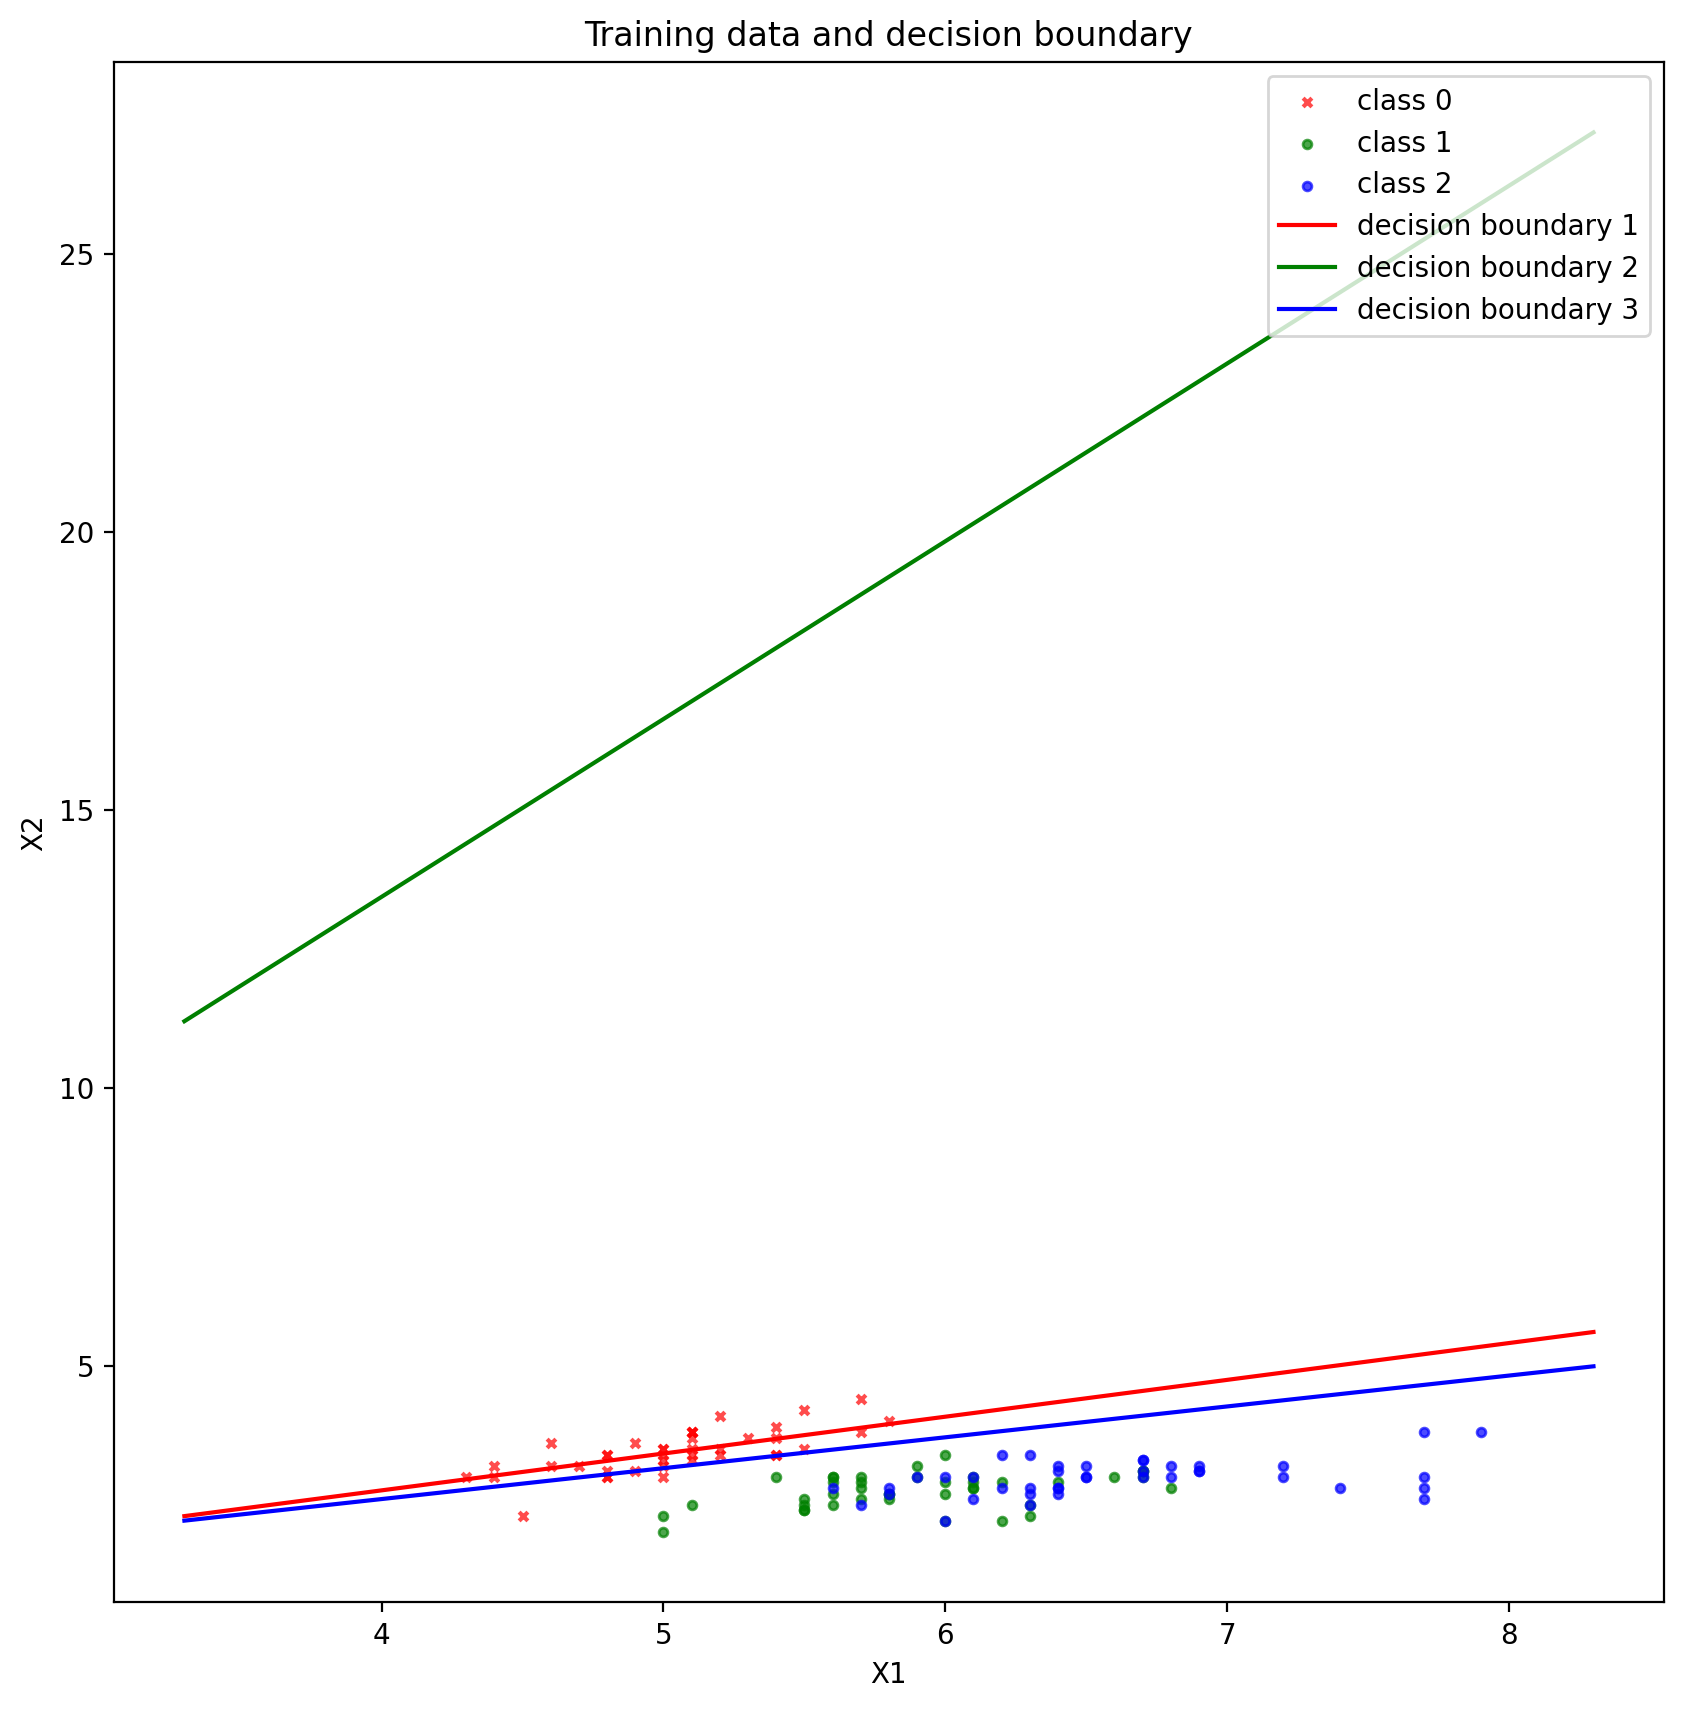

In [13]:
x1 = 1; x2 = 2
x = np.arange(np.min(X_train[:,1])-1,np.max(X_train[:,x1])+1,1.0)
y1 = (-w[0][0]-w[2][0]*x)/w[3][0]
y2 = (-w[0][1]-w[2][1]*x)/w[3][1]
y3 = (-w[0][2]-w[2][2]*x)/w[3][2]

plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

plt.xlabel('X1')
plt.ylabel('X2')
plt.plot(x,y1, color='r', label='decision boundary 1')
plt.plot(x,y2, color='g', label='decision boundary 2')
plt.plot(x,y3, color='b', label='decision boundary 3')
plt.title('Training data and decision boundary')

plt.legend(loc='upper right', fontsize=10)

### Results on test set

In [14]:
prediction1 = np.dot(X_test, w1)
prediction2 = np.dot(X_test, w2)
prediction3 = np.dot(X_test, w3)
preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
pred = np.argmax(preds, axis=1)

total_accuracy = np.sum(pred == y_test)*1.0/X_test.shape[0]
print ("Total test accuracy:", total_accuracy*100, "%.")

Total test accuracy: 76.66666666666667 %.


running for 0.5
gradient descent has converged after 285 iterations
w1 vector: [[0.07310838224710603], [0.124379781377944], [0.44994829450504137], [-0.6792764696320308], [-0.28988865237397965]]
gradient descent has converged after 84 iterations
w2 vector: [[-0.029742109436496175], [-0.11417504700194497], [-0.14770432116814106], [0.04619345355404409], [0.003540343262443726]]
gradient descent has converged after 1829 iterations
w3 vector: [[-0.4665110805487679], [-0.8607376805613346], [-0.6822599047825335], [1.2287043453220607], [1.1502834440268646]]
Total training accuracy: 77.5 %.
Total test accuracy: 76.66666666666667 %.
running for 2.0
gradient descent has converged after 301 iterations
w1 vector: [[0.09449510165430368], [0.14936058383346384], [0.5598990017582791], [-0.8609901548497929], [-0.38901841541499355]]
gradient descent has converged after 5901 iterations
w2 vector: [[1.3603793215268156], [0.615626816259639], [-1.8097989787215345], [0.6244471198171085], [-2.004329475470358]]


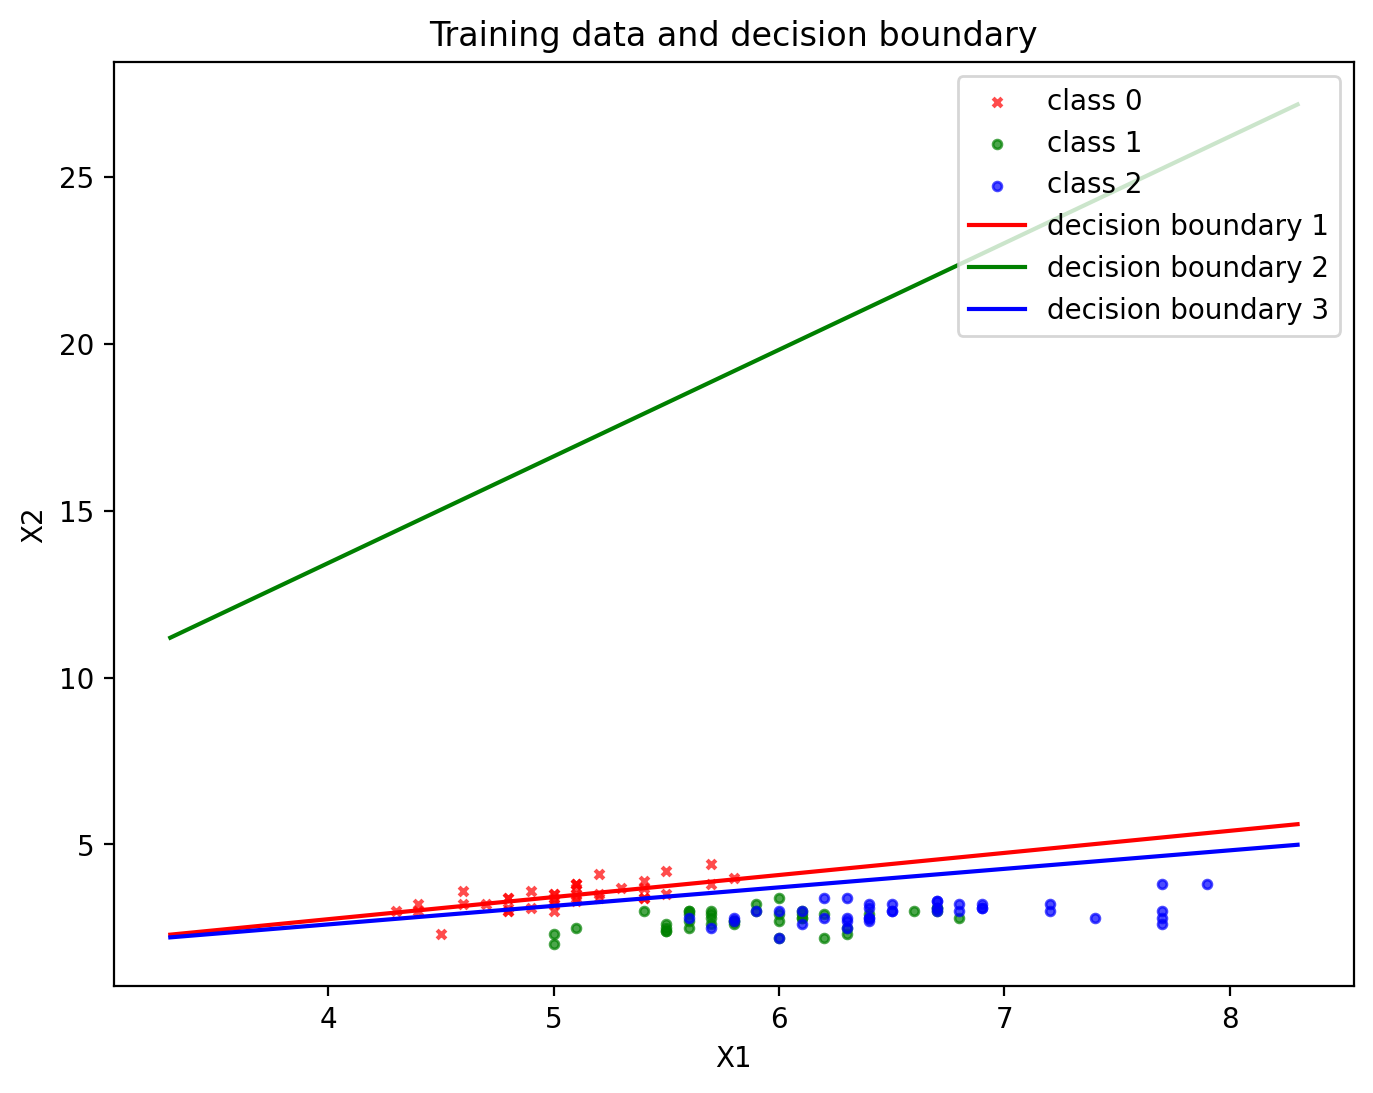

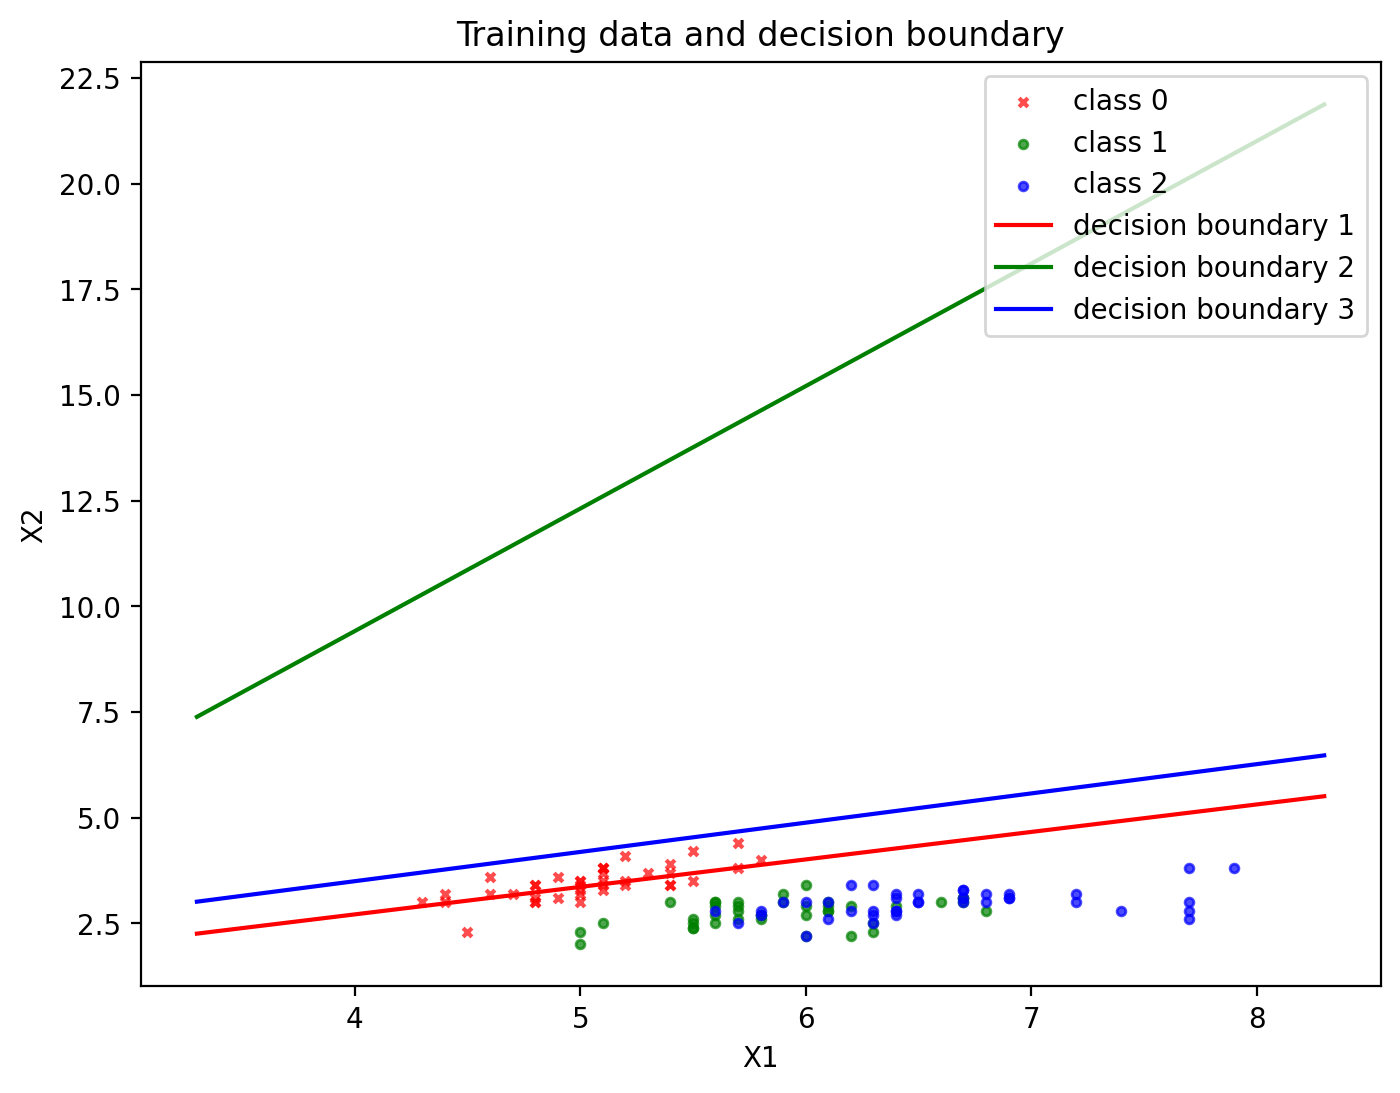

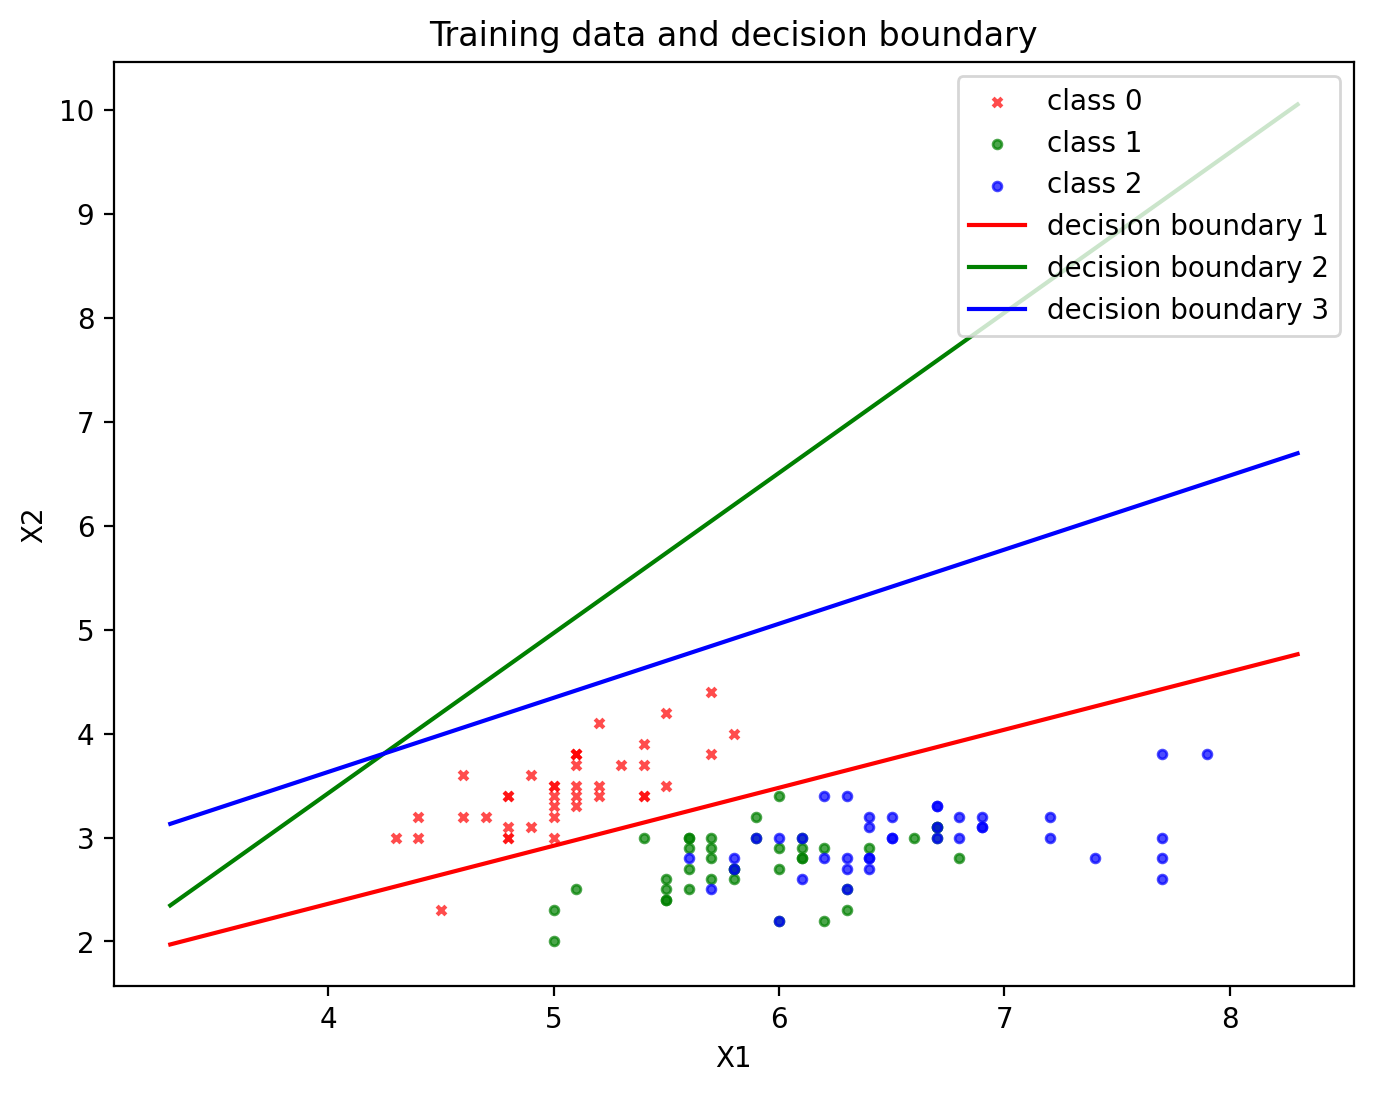

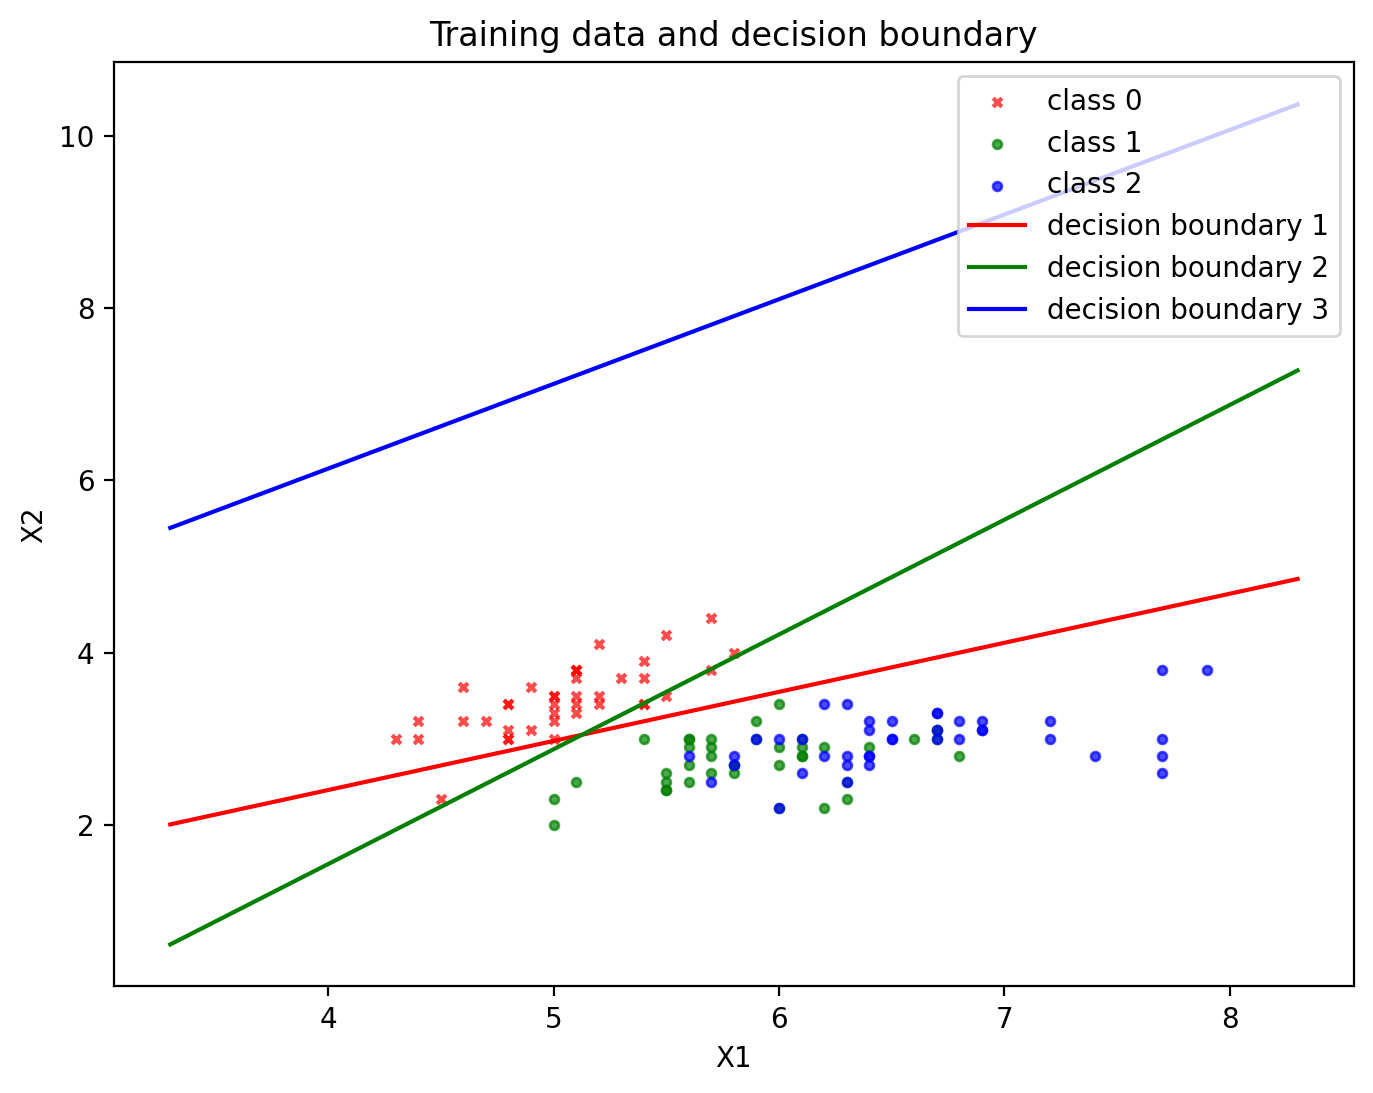

In [15]:
C_values = [0.5, 2.0, 5.0, 10.0]

for C in C_values:
    print('running for {}'.format(C))
    w1 = np.copy(train_svm(X_train, y_train1,C))
    print ("w1 vector:",  w1.tolist())
    w2 = np.copy(train_svm(X_train, y_train2,C))
    print ("w2 vector:",  w2.tolist())
    w3 = np.copy(train_svm(X_train, y_train3,C))
    print ("w3 vector:",  w3.tolist())
    w= np.concatenate((w1,w2,w3),axis=1)  
    prediction1 = np.dot(X_train, w1)
    prediction2 = np.dot(X_train, w2)
    prediction3 = np.dot(X_train, w3)
    preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
    pred = np.argmax(preds, axis=1)
    total_accuracy = np.sum(pred == y_train)*1.0/X_train.shape[0]
    print ("Total training accuracy:", total_accuracy*100, "%.")
    prediction1 = np.dot(X_test, w1)
    prediction2 = np.dot(X_test, w2)
    prediction3 = np.dot(X_test, w3)
    preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
    pred = np.argmax(preds, axis=1)
    total_accuracy = np.sum(pred == y_test)*1.0/X_test.shape[0]
    print ("Total test accuracy:", total_accuracy*100, "%.")
    plt.figure(figsize=(8, 6)) 
    x1 = 1; x2 = 2
    x = np.arange(np.min(X_train[:,1])-1,np.max(X_train[:,x1])+1,1.0)
    y1 = (-w[0][0]-w[2][0]*x)/w[3][0]
    y2 = (-w[0][1]-w[2][1]*x)/w[3][1]
    y3 = (-w[0][2]-w[2][2]*x)/w[3][2]

    plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
    plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
    plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.plot(x,y1, color='r', label='decision boundary 1')
    plt.plot(x,y2, color='g', label='decision boundary 2')
    plt.plot(x,y3, color='b', label='decision boundary 3')
    plt.title('Training data and decision boundary')

    plt.legend(loc='upper right', fontsize=10)
